In [4]:
#Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [5]:
# Reading in the dataframes

movie_info    = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t') # mi
tmdb          = pd.read_csv('zippedData/tmdb.movies.csv.gz') #tmdb
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz') # mb
movie_gross   = pd.read_csv("zippedData/bom.movie_gross.csv.gz") # mg
reviews       = pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

In [6]:
# Reading in the im.db database

# Filtering the database based directors who are still alive
conn = sqlite3.connect('zippedData/im.db/im.db')

q = """

WITH living_directors AS(
SELECT primary_title, start_year, genres, primary_name, death_year, primary_profession 
FROM movie_basics mb
INNER JOIN directors d
    ON mb.movie_id = d.movie_id
INNER JOIN persons p
    ON d.person_id = p.person_id
WHERE primary_profession LIKE '%director%'
GROUP BY mb.movie_id
HAVING p.death_year is NULL
)

SELECT * FROM living_directors

"""

alive_directors = pd.read_sql(q, conn)

OperationalError: unable to open database file

# **1. Cleaning Data**

1a. The Movie Database (tmdb)

In [7]:
# Adding a column that concantenates the title and release date of the movie for dataframe merging with movie_budgets dataframe
tmdb_title = tmdb['original_title']
tmdb_date = tmdb['release_date']
tmdb['title_and_year'] = tmdb_title + ' ' + tmdb_date.apply(lambda x: x[:4])

# Removing duplicates from tmdb
tmdb = tmdb.drop_duplicates(subset='id', keep='first')
tmdb = tmdb.drop_duplicates(subset='title_and_year', keep='first')

1b. The Numbers Movie Budgets (movie_budgets)

In [8]:
# Adding a matching column in movie_budgets to prepare for merge with tmdb dataframe
movie_budgets_title = movie_budgets['movie']
movie_budgets_date = movie_budgets['release_date']
movie_budgets['title_and_year'] = movie_budgets_title + ' ' + movie_budgets_date.apply(lambda x: x[-4:])

# Creating numeric columns to represent revenue and budget
movie_budgets['revenue'] = movie_budgets['worldwide_gross'].replace('[\$,]','', regex=True).astype(float)
movie_budgets['budget'] = movie_budgets['production_budget'].replace('[\$,]','', regex=True).astype(float)

# Removing duplicates
movie_budgets = movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

1c. IMDB (living_directors_df)

In [9]:
# Converting the sql database into a dataframe
alive_directors = pd.DataFrame(alive_directors)

# Adding a matching column in alive_directors dataframe to prepare for merge with tmdb and movie_budgets dataframes
alive_directors_title = alive_directors['primary_title']
alive_directors_year = alive_directors['start_year']
alive_directors['title_and_year'] = alive_directors_title + ' ' + alive_directors_year.apply(lambda x: str(x))

NameError: name 'alive_directors' is not defined

1d. Movie Gross (movie_gross)

In [10]:
# Adding a matching column in alive_directors dataframe to prepare for merge with tmdb and movie_budgets dataframes
movie_gross_title = movie_gross['title']
movie_gross_year = movie_gross['year']
movie_gross['title_and_year'] = movie_gross_title + ' ' + movie_gross_year.astype(str)

1e. Merging all the dataframes into the final dataframe called movies

In [11]:
# Merging the tmdb, movie_budgets, and alive_directors dataframes
movies = pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')
movies = pd.merge(movies, alive_directors, how='inner', on='title_and_year')
movies = pd.merge(movies, movie_gross, on='title_and_year')

"""
Filtering to rows that have greater than $0 in revenue. 
Research showed that many of these movies were released directly to streaming services, not theatres
"""
movies = movies.loc[movies['revenue'] != 0]

# Reset index due to dropping rows
movies.reset_index(inplace=True)

# Remove unnecessary columns
columns_to_drop = ['index',
                    'id_x',
                    'id_y',
                    'Unnamed: 0',
                    'primary_title',
                    'title_y', 
                    'original_title',
                    'year', 
                    'title_x', 
                    'domestic_gross_x',
                    'domestic_gross_y',
                    'start_year',
                    'release_date_x',
                    'movie',
                    'production_budget',
                    'foreign_gross',
                    'death_year']
movies.drop(columns_to_drop, axis=1, inplace=True)

# Remove rows that have missing values
movies.dropna(inplace=True)
movies.info()

NameError: name 'alive_directors' is not defined

# **2. Linear Regression**

### In this section we conducted linear regression tests on the movie's budget, vote average, and revenue to see how they are related

In [12]:
budget = movies['budget']
vote_average = movies['vote_average']

model = sm.OLS(vote_average, sm.add_constant(budget))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     44.10
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           4.26e-11
Time:                        12:55:03   Log-Likelihood:                -2130.3
No. Observations:                1602   AIC:                             4265.
Df Residuals:                    1600   BIC:                             4275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1539      0.029    212.299      0.000       6.097       6.211
budget      2.767e-09   4.17e-10      6.641      0.000    1.95e-09    3.58e-09
==============================================================================
Omnibus:                      112.851   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.259
Skew:                          -0.490   Prob(JB):                     1.34e-46
Kurtosis:                       4.485   Cond. No.                     8.82e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.82e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

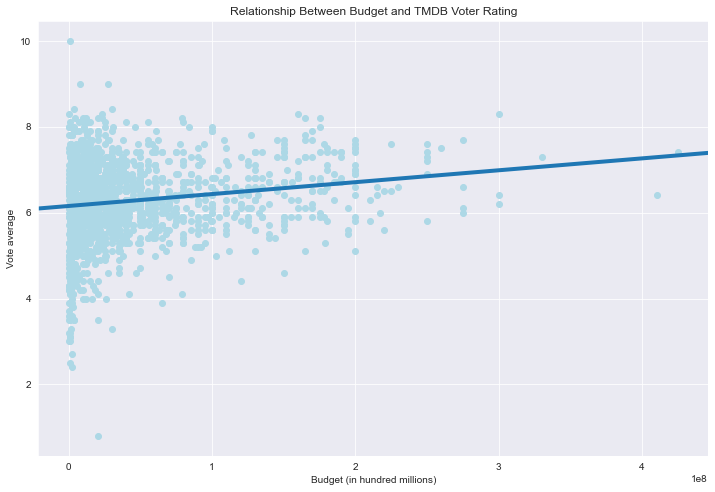

In [13]:
# Plotting the vote_average vs. budget
fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(budget, vote_average, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Vote average')
ax.set_title('Relationship Between Budget and TMDB Voter Rating')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

Our p-values demonstrate the model is statistically significant, but the R-squared value of 0.014 indicate that only 1.4% of the variability in vote average can be explained by budget. Therefore we conclude that a higher budget is not a very strong predictor for better voter ratings.

In [14]:
budget = movies['budget']
revenue = movies['revenue']
model=sm.OLS(revenue, sm.add_constant(budget))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     2773.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:55:06   Log-Likelihood:                -32357.
No. Observations:                1602   AIC:                         6.472e+04
Df Residuals:                    1600   BIC:                         6.473e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.747e+06   4.53e+06     -2.149      0.032   -1.86e+07   -8.52e+05
budget         3.4325      0.065     52.656      0.000       3.305       3.560
==============================================================================
Omnibus:                      888.180   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16176.277
Skew:                           2.190   Prob(JB):                         0.00
Kurtosis:                      17.938   Cond. No.                     8.82e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.82e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

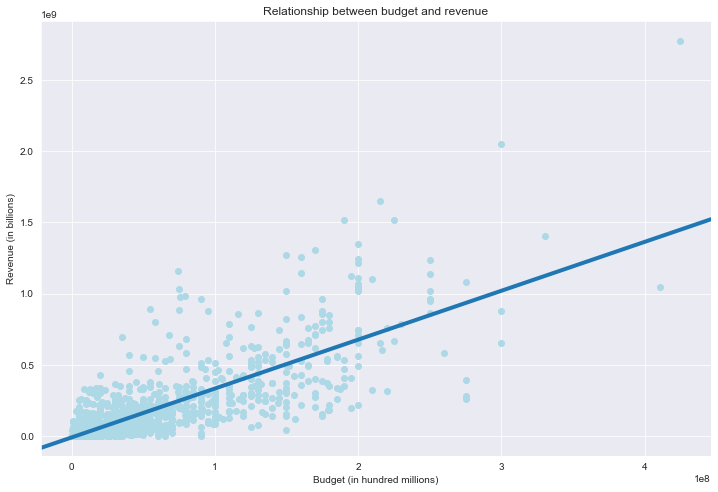

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(budget, revenue, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Revenue (in billions)')
ax.set_title('Relationship between budget and revenue')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

For every extra $1 spent in budget, the movie brings in on average $3.30 dollars extra in revenue

# **3. Visual Data Analysis**

In this section we will explore the most common studios and determine which genres, studios, and directors are the most profitable. We define profitability as the ratio of revenue to budget.

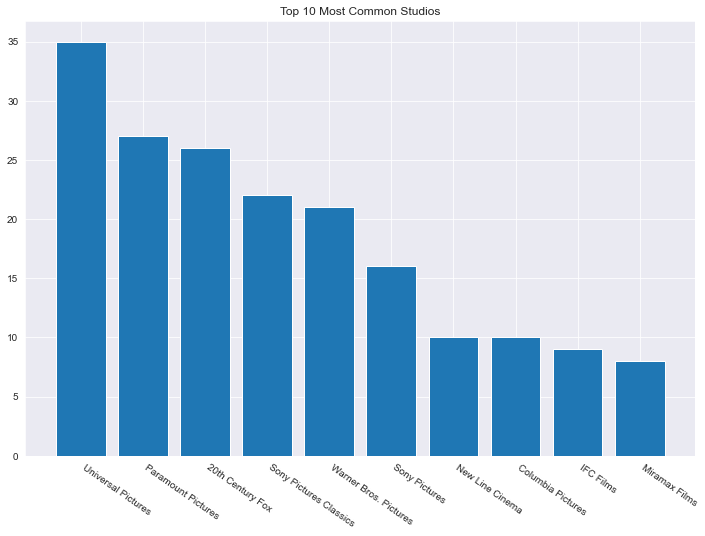

In [16]:
top_10_studio = movie_info['studio'].value_counts()[:10].index
top_10_studio_counts = movie_info['studio'].value_counts()[:10].values

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(top_10_studio, top_10_studio_counts)
ax.set_xticklabels(top_10_studio, rotation=-35, ha='left')
ax.set_title('Top 10 Most Common Studios');

In [17]:
movies['year'] = movies['release_date_y'].apply(lambda x: x[:4]).astype(int)
revenue_by_year = movies.groupby('year')['revenue'].mean()

In [18]:
X = revenue_by_year.index
y = revenue_by_year.values
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7147
Date:                Wed, 21 Jun 2023   Prob (F-statistic):              0.403
Time:                        12:55:14   Log-Likelihood:                -791.19
No. Observations:                  38   AIC:                             1586.
Df Residuals:                      36   BIC:                             1590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.555e+09   5.63e+09     -0.810      0.424    -1.6e+10    6.86e+09
x1          2.381e+06   2.82e+06      0.845      0.403   -3.33e+06    8.09e+06
==============================================================================
Omnibus:                       49.647   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.629
Skew:                           3.126   Prob(JB):                     1.67e-49
Kurtosis:                      13.138   Cond. No.                     2.53e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
tmdb_genres={
'Action':          28,
'Adventure':       12,
'Animation':       16,
'Comedy':          35,
'Crime':           80,
'Documentary':     99,
'Drama':           18,
'Family':          10751,
'Fantasy':         14,
'History':         36,
'Horror':          27,
'Music':           10402,
'Mystery':        9648,
'Romance':         10749,
'Science Fiction': 878,
'TV Movie':        10770,
'Thriller':        53,
'War':             10752,
'Western':         37}

# Reverses the key and values of the tmdb_genres dictionary
tmdb_genres_swap = {y:x for x,y in tmdb_genres.items()}

# Converts the ids in genre_ids to a list from a string and replaces the id with its corresponding genre
movies['genre_ids'] = movies['genre_ids'].apply(lambda x: [tmdb_genres_swap.get(int(id), 'X') for id in x.strip('[]').split(',') if len(id) != 0])

# Resetting index and dropping duplicate columns again after removing rows
movies.reset_index(inplace=True)
movies.drop(['index'], axis=1, inplace=True)

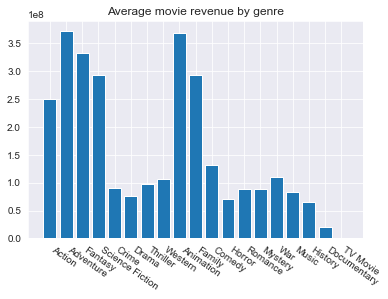

In [20]:
genre_n_revenue = {}

"""
Loops through each movie and appends a list of revenues associated with each of the movies' genres
The dictionary will result in keys representing the genres and the values being a list of revenues
"""
for row in movies.index:
    g_ids = movies.iloc[row]['genre_ids']
    rev = movies.iloc[row]['revenue']
    for g in g_ids:
        if g in genre_n_revenue.keys():
            genre_n_revenue[g] = np.append(genre_n_revenue[g], rev)
        else:
            genre_n_revenue[g] = np.array([rev])

genre_and_revenue_average = {}

# Adds a key (genre) and value (average revenue) to the genre_and_revenue_average dictionary
for g in genre_n_revenue.keys():
    genre_and_revenue_average[g] = genre_n_revenue[g].mean()

fig, ax = plt.subplots()
ax.bar(genre_and_revenue_average.keys(), genre_and_revenue_average.values())
ax.set_title('Average movie revenue by genre')
ax.set_xticklabels(genre_and_revenue_average.keys(), rotation=-35, ha='left');

In [21]:
# Checking to see if genre has a statistically significant impact on revenue
stats.f_oneway(*genre_n_revenue.values())

F_onewayResult(statistic=43.39958350120747, pvalue=2.295278557471982e-140)

Since the p-value is extremely small and less than 0.05, we conclude that genre does have a statistically significant impact on revenue.

We will now replace the genre ids with the actual genre names, and then analyze the ratio of revenue to budget by genre.

In [22]:
movies['revenue_to_budget'] = movies['revenue'] / movies['budget']

In [23]:
genre_rois = {}

for row in movies.index:
    g_ids = movies.iloc[row]['genre_ids']
    rtb = movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in genre_rois.keys():
            genre_rois[g] = np.append(genre_rois[g], rtb)
        else:
            genre_rois[g] = np.array([rtb])

genre_rois_average = {}
for g in genre_rois.keys():
    genre_rois_average[g] = genre_rois[g].mean()

genre_rois_average

{'Action': 2.6868885177169846,
 'Adventure': 3.200190717366324,
 'Fantasy': 3.1889911439508136,
 'Science Fiction': 3.463059609365915,
 'Crime': 2.5984356939759077,
 'Drama': 3.096735481371128,
 'Thriller': 4.956145032683743,
 'Western': 1.4205474291115467,
 'Animation': 3.7410233947975837,
 'Family': 3.3727367292520847,
 'Comedy': 3.3472586958147525,
 'Horror': 9.57833908729756,
 'Romance': 3.7728757688000893,
 'Mystery': 4.987230668627534,
 'War': 2.356601874654575,
 'Music': 3.1596736636080336,
 'History': 2.516939570721482,
 'Documentary': 2.873390643013942,
 'TV Movie': 0.0}

#### Does genre have a statistically significant impact on return on investment?
Before we make recommendations on which genres to invest in, we must first determine whether genre is statistically significant in our data when it comes to predicting return on investment.

In [24]:
stats.f_oneway(*genre_rois.values())

F_onewayResult(statistic=4.462152751688852, pvalue=9.699485602432634e-10)

Since our p-value is less than 0.05, we conclude that there is a statistically significant difference in return on investment by genre. Therefore we will conduct further analysis to see which genres are the best investments.

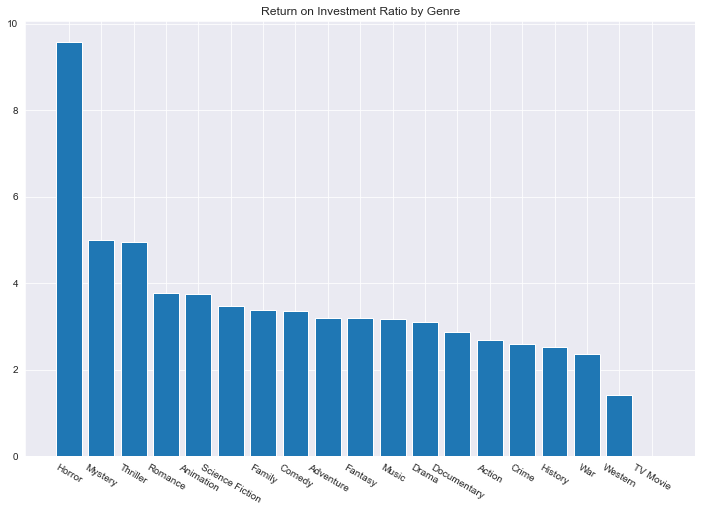

In [25]:
genre_ids = list(genre_rois_average.keys())
rois = list(genre_rois_average.values())
genres_and_rois = pd.DataFrame(data=rois, index=genre_ids, columns={'Return on Investment'})
genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(genres_and_rois.index, genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre')
ax.set_xticklabels(genres_and_rois.index, rotation=-30, ha='center');

We can see that horror has the highest return on investment, followed by mystery and thriller.

## What about for current movies only? Are the results different?
Our investor asked us to look specifically at how movies are currently doing in the box office, so we will filter the results further to movies released after 2017.

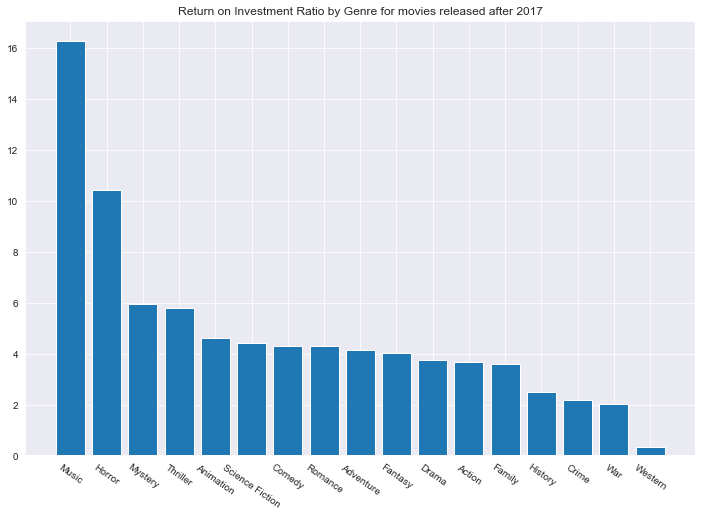

In [ ]:
#repeating the same steps as above, but for new movies only

new_movies=movies.loc[movies['year']>2017]
new_movies.reset_index(inplace=True)

new_genre_rois={}
for row in new_movies.index:
    g_ids=new_movies.iloc[row]['genre_ids']
    rtb=new_movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in new_genre_rois.keys():
            new_genre_rois[g]=np.append(new_genre_rois[g], rtb)
        else:
            new_genre_rois[g]=np.array([rtb])

new_genre_rois_average={}
for g in new_genre_rois.keys():
    new_genre_rois_average[g]=new_genre_rois[g].mean()

assert(stats.f_oneway(*new_genre_rois.values())[1]<0.05)

new_movies_genres_and_rois=pd.DataFrame(index=new_genre_rois_average.keys(), data=new_genre_rois_average.values(), columns={'Return on Investment'})
new_movies_genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(new_movies_genres_and_rois.index, new_movies_genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre for movies released after 2017')
ax.set_xticklabels(new_movies_genres_and_rois.index, rotation=-35, ha='center');


Horror, mystery, and thriller are still among the most profitable genres, but music has been the most profitable of all recently.

Therefore the top genres we recommend are Horror, Music, Thriller, and Mystery.

Next we will look to see which directors have been the most profitable within these genres.

In [ ]:
music_directors = movies.loc[movies['genres'].str.contains('Music')].groupby(by='primary_name').sum()
music_directors['revenue_to_budget'] = music_directors['revenue'] / music_directors['budget']
music_directors.sort_values(by='revenue_to_budget', ascending=False)[0:5]

,revenue,budget,popularity,vote_average,vote_count,year,revenue_to_budget
primary_name,,,,,,,
Damien Chazelle,465320200.0,23300000.0,45.059,16.3,17936,4030,19.970824
Bryan Singer,894985342.0,55000000.0,37.197,8.1,7629,2018,16.272461
Elizabeth Banks,287625468.0,29000000.0,18.469,6.8,3599,2015,9.918120
Gregory Jacobs,123660597.0,14500000.0,8.681,6.2,1110,2015,8.528317
Jon M. Chu,99034125.0,13000000.0,8.602,5.1,240,2011,7.618010
